/Users/kristianlarsen/Documents/skole/7. semester/ProgGeo/LoD2Creator/.venv/lib/python3.11/site-packages/shapely/constructive.py:1353: RuntimeWarning: divide by zero encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/kristianlarsen/Documents/skole/7. semester/ProgGeo/LoD2Creator/.venv/lib/python3.11/site-packages/shapely/constructive.py:1353: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


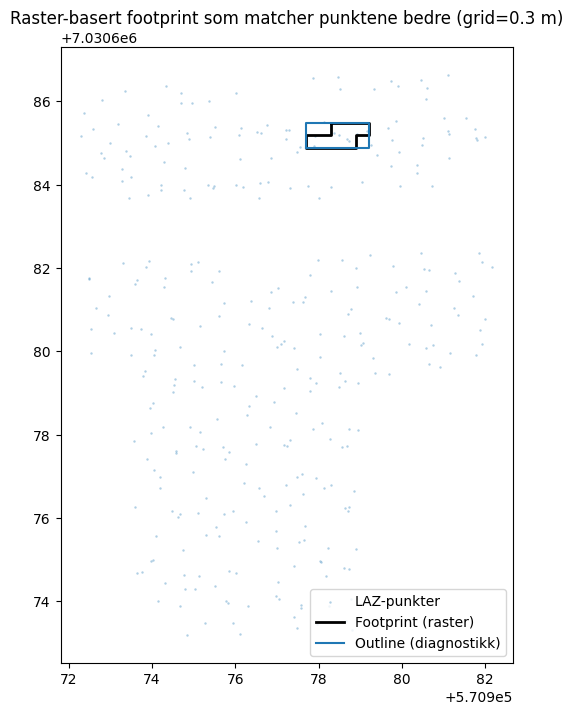

In [7]:
# =========================
# PARAMETRE
# =========================
# --- Notebook Celle: Robust footprint fra punktsky via raster-kontur + plot sammen med rektangler ---

import math, numpy as np, laspy
from shapely.geometry import Polygon, Point, box, MultiPolygon
from shapely.ops import unary_union
from shapely.affinity import rotate
import matplotlib.pyplot as plt

# ======= PARAMETRE =======
LAZ_PATH = "sample_roofdata_50/10444144.laz"   # <-- sett sti til .laz du vil vise
DOWNSAMPLE_EVERY = 3                 # små tall for bedre kontur (3–5)
Z_KEEP_PCTL = (0.15, 0.85)           # behold midtre 70% av høydene (juster ved behov)
GRID = 0.30                          # rutenett (m). 0.25–0.5 gir bra kontur
MIN_PTS_PER_CELL = 2                 # terskel for å markere celle som okkupert
CLOSE_RADIUS_CELLS = 1               # “closing” (1 eller 2 typisk)
HOLE_FILL_MIN_CELLS = 20             # fyll små hull (areal i celler)
RECT_MIN_AREA = 1.0
MAX_ITERS = 400

# ======= Hjelpere =======
def read_laz_xyz(path, down=1):
    with laspy.open(path) as f: las = f.read()
    x = np.asarray(las.x, float); y = np.asarray(las.y, float); z = np.asarray(las.z, float)
    if down and down > 1: x, y, z = x[::down], y[::down], z[::down]
    return x, y, z

def pca_main_angle(x, y):
    XY = np.column_stack([x, y]) - np.array([[x.mean(), y.mean()]])
    C = np.cov(XY.T)
    w, V = np.linalg.eigh(C)
    v = V[:, np.argmax(w)]
    ang = math.degrees(math.atan2(v[1], v[0]))
    return ang

def rot(geom, ang, origin=(0,0), inv=False):
    return rotate(geom, (-ang if not inv else ang), origin=origin, use_radians=False)

def rasterize_points(x, y, cell):
    minx, maxx = x.min(), x.max()
    miny, maxy = y.min(), y.max()
    nx = int(math.ceil((maxx-minx)/cell)); ny = int(math.ceil((maxy-miny)/cell))
    if nx==0 or ny==0: return None, (minx, miny), 0, 0
    grid = np.zeros((ny, nx), dtype=np.int32)
    ix = np.clip(((x - minx)/cell).astype(int), 0, nx-1)
    iy = np.clip(((y - miny)/cell).astype(int), 0, ny-1)
    for j,i in zip(iy, ix): grid[j,i] += 1
    return grid, (minx, miny), nx, ny

def binary_from_counts(grid, thr):
    return (grid >= thr).astype(np.uint8)

def binary_close(bw, rad=1):
    if rad <= 0: return bw.copy()
    H, W = bw.shape
    out = bw.copy()
    # dilation
    for _ in range(rad):
        dil = out.copy()
        for j in range(H):
            js = max(0,j-1); je = min(H,j+2)
            for i in range(W):
                is_ = max(0,i-1); ie = min(W,i+2)
                if out[js:je, is_:ie].max(): dil[j,i]=1
        out = dil
    # erosion
    for _ in range(rad):
        ero = out.copy()
        for j in range(H):
            js = max(0,j-1); je = min(H,j+2)
            for i in range(W):
                is_ = max(0,i-1); ie = min(W,i+2)
                if out[js:je, is_:ie].min()==0: ero[j,i]=0
        out = ero
    return out

def fill_small_holes(bw, min_cells=20):
    # Fyll 4-tilkoblede hull ved enkel flood-fill fra kant
    H,W = bw.shape
    vis = np.zeros_like(bw)
    from collections import deque
    q = deque()
    # start fra utside: legg kant-pixler der bw==0
    for j in range(H):
        for i in (0, W-1):
            if bw[j,i]==0 and vis[j,i]==0: vis[j,i]=1; q.append((j,i))
    for i in range(W):
        for j in (0, H-1):
            if bw[j,i]==0 and vis[j,i]==0: vis[j,i]=1; q.append((j,i))
    # flood
    while q:
        j,i = q.popleft()
        for dj,di in ((1,0),(-1,0),(0,1),(0,-1)):
            jj,ii = j+dj, i+di
            if 0<=jj<H and 0<=ii<W and bw[jj,ii]==0 and vis[jj,ii]==0:
                vis[jj,ii]=1; q.append((jj,ii))
    # områder med 0 men ikke visitert = hull; fyll små
    fill = bw.copy()
    for j in range(H):
        for i in range(W):
            if bw[j,i]==0 and vis[j,i]==0:
                # finn komponentstørrelse (BFS)
                comp = []
                q = [(j,i)]
                vis2 = { (j,i) }
                while q:
                    jj,ii = q.pop()
                    comp.append((jj,ii))
                    for dj,di in ((1,0),(-1,0),(0,1),(0,-1)):
                        yx = (jj+dj, ii+di)
                        if 0<=yx[0]<H and 0<=yx[1]<W and bw[yx]==0 and yx not in vis2 and vis[yx]==0:
                            vis2.add(yx); q.append(yx)
                if len(comp) <= min_cells:
                    for (jj,ii) in comp: fill[jj,ii]=1
    return fill

def bw_to_polygon(bw, origin, cell):
    minx, miny = origin
    polys = []
    H,W = bw.shape
    for j in range(H):
        for i in range(W):
            if bw[j,i]:
                x0 = minx + i*cell; y0 = miny + j*cell
                polys.append(box(x0,y0, x0+cell, y0+cell))
    if not polys: return None
    u = unary_union(polys)
    if isinstance(u, MultiPolygon):
        # velg største
        u = max(u.geoms, key=lambda g: g.area)
    return u

def maximal_rectangle_cover(poly: Polygon, angle_deg=None, cell=0.5, max_iters=200, min_area=1.0):
    # (samme som tidligere versjon – forkortet her: behold din fungerende implementasjon)
    mrr = poly.minimum_rotated_rectangle
    x, y = mrr.exterior.coords.xy
    edges = [((x[i], y[i]), (x[i+1], y[i+1])) for i in range(4)]
    lens = [math.hypot(b[0]-a[0], b[1]-a[1]) for a,b in edges]
    (ax,ay),(bx,by) = edges[int(np.argmax(lens))]
    if angle_deg is None:
        angle_deg = math.degrees(math.atan2(by-ay, bx-ax))

    def rotate_to_frame(geom, angle_deg):
        return rotate(geom, -angle_deg, origin=(0,0), use_radians=False)
    def rotate_from_frame(geom, angle_deg):
        return rotate(geom,  angle_deg, origin=(0,0), use_radians=False)

    poly_r = rotate_to_frame(poly, angle_deg)
    minx, miny, maxx, maxy = poly_r.bounds
    nx = int(math.ceil((maxx - minx) / cell))
    ny = int(math.ceil((maxy - miny) / cell))
    if nx==0 or ny==0: return [], angle_deg

    # binær maske
    from shapely.geometry import Point
    mask = np.zeros((ny, nx), dtype=np.uint8)
    cxv = minx + (np.arange(nx) + 0.5) * cell
    cyv = miny + (np.arange(ny) + 0.5) * cell
    for j, cy in enumerate(cyv):
        pts_row = [Point(cx, cy) for cx in cxv]
        inside = np.array([poly_r.contains(p) for p in pts_row], dtype=np.uint8)
        mask[j, :] = inside

    def largest_rect(binary):
        H,W = binary.shape
        heights = np.zeros(W, dtype=int)
        best = (0,0,0,0,0)
        for top in range(H):
            heights = heights + binary[top]
            stack=[]; c=0
            while c<=W:
                cur = heights[c] if c<W else 0
                if not stack or cur>=heights[stack[-1]]:
                    stack.append(c); c+=1
                else:
                    h = heights[stack.pop()]
                    l = stack[-1]+1 if stack else 0
                    r = c
                    area = h*(r-l)
                    if area>best[0]:
                        bottom = top+1; t = bottom-h
                        best=(area,t,l,bottom,r)
        return best

    rects=[]; it=0
    while it<max_iters and mask.any():
        it+=1
        area,t,l,b,r = largest_rect(mask)
        if area==0: break
        from shapely.geometry import box
        rect_r = box(minx+l*cell, miny+t*cell, minx+r*cell, miny+b*cell).intersection(poly_r)
        if rect_r.is_empty or rect_r.area < min_area:
            mask[t:b, l:r] = 0; continue
        rects.append(rotate_from_frame(rect_r, angle_deg))
        mask[t:b, l:r] = 0
    return rects, angle_deg

# ======= 1) Les og filtrer =======
x, y, z = read_laz_xyz(LAZ_PATH, DOWNSAMPLE_EVERY)
z0, z1 = np.quantile(z, Z_KEEP_PCTL)
keep = (z>=z0) & (z<=z1)
x, y, z = x[keep], y[keep], z[keep]

# ======= 2) Robust hovedakse =======
angle = pca_main_angle(x, y)

# ======= 3) Rasteriser og bygg footprint =======
grid, origin, nx, ny = rasterize_points(x, y, GRID)
assert grid is not None, "Tom raster – sjekk input."
bw = binary_from_counts(grid, MIN_PTS_PER_CELL)
bw = binary_close(bw, CLOSE_RADIUS_CELLS)
bw = fill_small_holes(bw, HOLE_FILL_MIN_CELLS)
footprint = bw_to_polygon(bw, origin, GRID)
assert footprint and not footprint.is_empty, "Kunne ikke bygge footprint."

outline_rect = footprint.minimum_rotated_rectangle  # kun for visning/diagnostikk

# ======= 4) Rektangler over footprint =======
rects, used_angle = maximal_rectangle_cover(footprint, angle_deg=angle, cell=GRID, max_iters=MAX_ITERS, min_area=RECT_MIN_AREA)

# ======= 5) Plot =======
fig, ax = plt.subplots(figsize=(8,8)); ax.set_aspect('equal','box')
ax.scatter(x, y, s=3, alpha=0.35, linewidths=0, label="LAZ-punkter")
fx, fy = footprint.exterior.xy; ax.plot(fx, fy, 'k-', lw=2, label="Footprint (raster)")
ox, oy = outline_rect.exterior.xy; ax.plot(ox, oy, '-', lw=1.5, label="Outline (diagnostikk)")

for r in rects:
    rx, ry = r.exterior.xy
    ax.fill(rx, ry, alpha=0.25)
    ax.plot(rx, ry, lw=1)

ax.set_title(f"Raster-basert footprint som matcher punktene bedre (grid={GRID} m)")
ax.legend(loc="best"); plt.show()
